# 🎨 color mapping

In [ ]:
#| default_exp utils.colormap

In [ ]:
# |hide
# Stuff usef for dev/exploration purposes only.

from nbdev.showdoc import *
from fastcore.test import test_eq, is_close
from matplotlib import pyplot as plt
from lovely_numpy import lo

In [ ]:
# |export
from typing import Optional as  O
import numpy as np
import matplotlib as mpl, matplotlib.cm as cm
from matplotlib.colors import Colormap, to_rgba

from lovely_numpy.repr_rgb import rgb

In [ ]:
# |hide

png_meta = {
        "Software": "Matplotlib, https://matplotlib.org/"
}

%config InlineBackend.print_figure_kwargs = { "metadata" : png_meta, "pad_inches": 0, "bbox_inches": 0}
%config InlineBackend.figure_format = "png"

In [ ]:
# |exporti

def get_cmap(cmap: str) -> Colormap:
    # Matplotlib changed the colormap interface in version 3.6, and immediately
    # marked the old one as deprecated with a warning. I want to suppot
    # both for the time being, and avoid the warning for people using 3.6+.
    major, minor, *rest = mpl.__version__.split(".")
    assert int(major) == 3 # Drop this compat code when mpl is at 4.0

    if int(minor) <= 5:
        return cm.get_cmap(cmap)
    else:
        return mpl.colormaps[cmap]


In [ ]:
# |hide
in_stats = ( (0.485, 0.456, 0.406),(0.229, 0.224, 0.225) )

image = np.load("mysteryman.npy").transpose(1,2,0)
image_01 = ((image * np.array(in_stats[1])) + np.array(in_stats[0]))# .clip(0, 1)
print(lo(image_01)) # Image scale to [0..1] range

image_11 = (image_01 * 2) - 1
print(lo(image_11)) # Image scaled to [-1..1] range


array[196, 196, 3] n=115248 x∈[-4.053e-09, 1.000] μ=0.361 σ=0.248
array[196, 196, 3] n=115248 x∈[-1.000, 1.000] μ=-0.277 σ=0.496


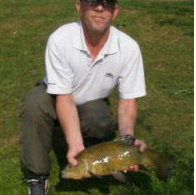

In [ ]:
lo(image_01).rgb

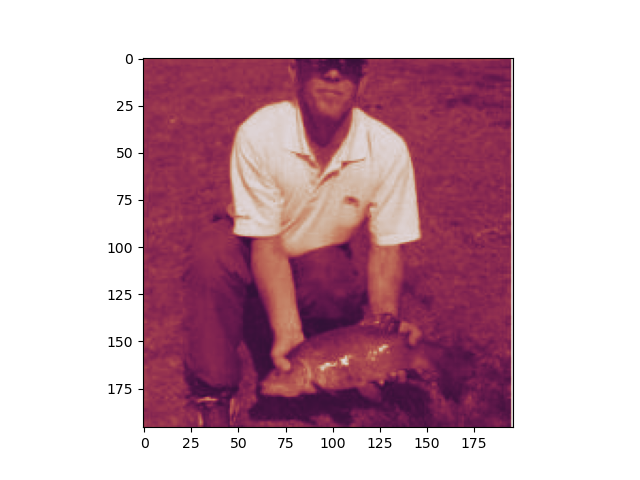

In [ ]:
# |hide
plt.imshow(image_01[:,:,1], cmap="twilight", vmin=-1); # One single channel.

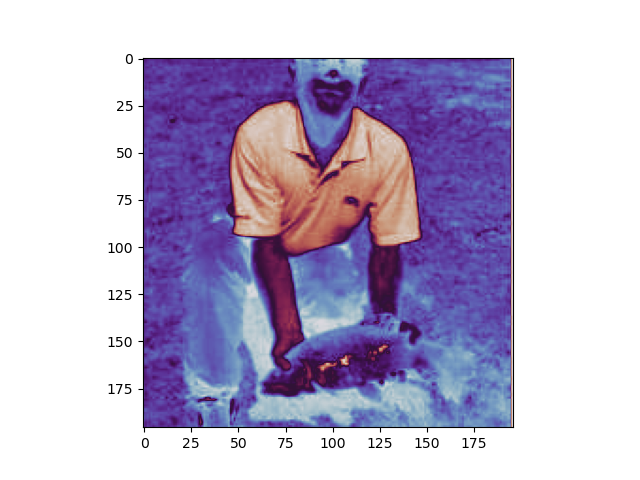

In [ ]:
plt.imshow(image_11[:,:,1], cmap="twilight", vmin=-1); # One single channel.

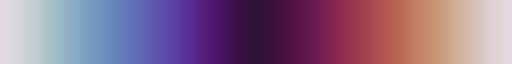

In [ ]:
# |hide
cmap = get_cmap("twilight")
cmap

In [ ]:
# |hide
cmap(0), cmap(0.5), cmap(1) # Maps float [0, 1] -> RGBA values. Works on np arrays.

((0.8857501584075443, 0.8500092494306783, 0.8879736506427196, 1.0),
 (0.18488035509396164, 0.07942573027972388, 0.21307651648984993, 1.0),
 (0.8837852019553906, 0.8507294054031063, 0.8872322209694989, 1.0))

In [ ]:
# |hide
# cmap has a lookup table with the structure:
#  0 ... N -> RGBA values for [0 , 1]
#        N+1 -> RGBA for below min
#        N+2 -> RGBA for above max
#        N+3 -> RGBA for NaN
print(cmap.N)
print(lo(cmap._lut).v) 

510
array[513, 4] n=2052 x∈[0., 1.000] μ=0.626 σ=0.305
array([[0.88575016, 0.85000925, 0.88797365, 1.        ],
       [0.8837852 , 0.85072941, 0.88723222, 1.        ],
       [0.88172231, 0.85127594, 0.88638057, 1.        ],
       ...,
       [0.88575016, 0.85000925, 0.88797365, 1.        ],
       [0.88571155, 0.85002186, 0.88572539, 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])


array[196, 196] n=38416 x∈[0.508, 1.000] μ=0.697 σ=0.109
array[196, 196] i64 n=38416 x∈[259, 510] μ=355.525 σ=55.395
array[196, 196, 4] n=153664 x∈[0.067, 1.000] μ=0.549 σ=0.322


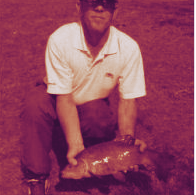

In [ ]:
# |hide

# Same, but use tensors
lut = cmap._lut.copy()

# Convert values between [-1 .. 1] to [0, 1]
vals = (image_01[:,:,1] + 1)/2


lut_idxs = (vals * cmap.N).astype(np.int64)
# lut_idxs = ((image)[:,:,0] * 255).astype(np.uint8).astype(np.int64)

print(lo(vals))
print(lo(lut_idxs))

# Use F.embedding as a table lookup 
mapped = lut.take(lut_idxs, axis=0, mode="clip")
# embedding(lut_idxs, tensor_cmap)

print(lo(mapped))
lo(mapped).rgb(cl=True) # imshow is fine with channel-last RGBA.

In [ ]:
# |hide
# This works for tensors with arbitraty dimensions
# The RGBA is always slapped on as the last dimension.

image_batch = image_01[None].repeat(10, axis=0)
print(lo(image_batch))

vals = (image_batch + 1)/2

lut_idxs = (vals * cmap.N).astype(np.int64)


lut_idxs = (image_batch * cmap.N).astype(np.int64)
mapped = lut.take(lut_idxs, axis=0, mode="clip")

print(lo(mapped))

array[10, 196, 196, 3] n=1152480 x∈[-4.053e-09, 1.000] μ=0.361 σ=0.248
array[10, 196, 196, 3, 4] n=4609920 x∈[0.066, 1.000] μ=0.647 σ=0.272


This works, but now this would be interpreted as a 1960 196x3 RGBA images.

What I had in ming was more like 30 196x196 RGBA images (3 channels for each of the 10 images).

Keep this in mind when using cmap.

array[10, 3, 196, 196] n=1152480 x∈[-4.053e-09, 1.000] μ=0.361 σ=0.248
array[10, 3, 196, 196, 4] n=4609920 x∈[0.067, 1.000] μ=0.534 σ=0.334


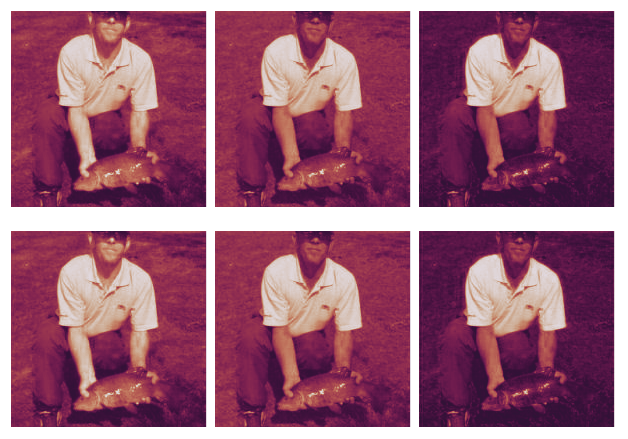

In [ ]:
image_batch = image_01.transpose(2,0,1)[None].repeat(10, axis=0)
print(lo(image_batch))

vals = (image_batch + 1)/2
lut_idxs = (vals * cmap.N).astype(np.int64)

mapped = lut.take(lut_idxs, axis=0, mode="clip")

print(lo(mapped))
lo(mapped[:2]).rgb # First 2 of the images, each as 3 channels.

array[196, 196] n=38416 x∈[-0.050, 1.050] μ=0.699 σ=0.191 +Inf! -Inf! NaN!
array[196, 196] i64 n=38416 x∈[254, 512] μ=381.642 σ=80.558
array[196, 196, 4] n=153664 x∈[0., 1.000] μ=0.564 σ=0.353


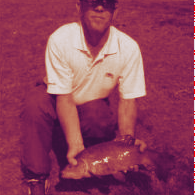

In [ ]:
# |hide
# Handle clipping and NaNs.
lut = cmap._lut.copy()
N = cmap.N

bad_image = image_01.copy()

bad_image[0:32, 0:32,   0] = float("-inf")
bad_image[0:32, 32:64,  0] = -1.1 # Below min
bad_image[0:32, 64:96,  0] = float("nan")
bad_image[0:32, 96:128, 0] = 1.1 # Above max
bad_image[0:32, 128:160,0] = float("+inf")
bad_image[0:32, 160:176,0] = 0.
bad_image[0:32, 176:,0] = 1.


bad_image_01 = ((bad_image + 1.) /2.)

lut[N] = np.array([0., 0, 1, 1]) # Blue for below min
lut[N+1] = np.array([1., 0, 0, 1]) # Red for above max
lut[N+2] = np.array([1., 1, 0, 1]) # Yellow for NaNs

with np.errstate(invalid="ignore"): # Supress the warnings
    lut_idxs = (bad_image_01 * (N-1)).astype(np.int64)
lut_idxs[ bad_image_01 < 0. ] = N
lut_idxs[ bad_image_01 > 1. ] = N+1
lut_idxs[ np.isnan(bad_image_01)] = N+2

mapped = lut.take(lut_idxs, axis=0, mode="clip")

print(f"{lo(bad_image_01[:,:,0])}")
print(f"{lo(lut_idxs[:,:,0])}")
print(f"{lo(mapped[:,:,0])}")
lo(mapped[:,:,1]).rgb # Show the R channel

#### Extend the lut to cover +/-inf too.

In [ ]:
# |hide

tensor_cmap_ninf = np.array([[0, 1, 1, 1]]) # Cyan for -inf
tensor_cmap_pinf = np.array([[1, 0, 1, 1]]) # Fuchsia for +inf

# Add mapping for -inf at positoin +4 and +inf at N+5
lut = np.concatenate([
    lut,
    tensor_cmap_ninf,
    tensor_cmap_pinf])

array[196, 196, 3] i64 n=115248 x∈[254, 514] μ=353.819 σ=72.569


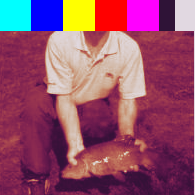

In [ ]:
# |hide

lut_idxs[ np.isneginf(bad_image) ] = cmap.N+3
lut_idxs[ np.isposinf(bad_image) ] = cmap.N+4

mapped = lut.take(lut_idxs, axis=0, mode="clip")

print(lo(lut_idxs))

lo(mapped[:,:,0]).rgb

In [ ]:
# |export

class InfCmap():
    """
    Matplotlib colormap extended to have colors for +/-inf

    Parameters extept `cmap` are matplotlib color strings.
    """
    def __init__(self,
                 cmap:  Colormap, # Base matplotlib colormap
                 below: O[str] =None, # Values below 0
                 above: O[str] =None, # Values above 1
                 nan:   O[str] =None, # NaNs
                 ninf:  O[str] =None, # -inf
                 pinf:  O[str] =None, # +inf
                ):
        _ = cmap(0) # one call to make sure the cmap is initialized
        lut = cmap._lut.copy()
        cmax = cmap.N-1
        assert len(lut) == cmap.N+3, "Unexpected colormap LUT size"
        
        
        if below: lut[cmax+1] = np.array(to_rgba(below))
        if above: lut[cmax+2] = np.array(to_rgba(above))
        if nan: lut[cmax+3] = np.array(to_rgba(nan))
        
        # For +/- inf, use above/below as defaults.
        tensor_cmap_ninf = np.array(to_rgba(ninf)) if ninf else lut[cmax+1]
        tensor_cmap_pinf = np.array(to_rgba(pinf)) if pinf else lut[cmax+2]

        # Remove the alpha channel, it causes problems in pad_frame_gutters().
        self.lut = np.concatenate([ lut, tensor_cmap_ninf[None], tensor_cmap_pinf[None] ])[:,:3]
        self.cmax = cmax

    def __call__(self, t: np.ndarray):
        vals = ((t + 1) / 2)
        cmax = self.cmax
        with np.errstate(invalid='ignore'):
            lut_idxs = (vals * cmax).astype(np.int64)
        
        lut_idxs[ vals < 0. ] = cmax+1
        lut_idxs[ vals > 1. ] = cmax+2
        lut_idxs[ np.isnan(t)] = cmax+3
        

        lut_idxs[ np.isneginf(t) ] = cmax+4
        lut_idxs[ np.isposinf(t) ] = cmax+5
        
        return self.lut.take(lut_idxs, axis=0, mode="clip") # RGB added as color-last.         

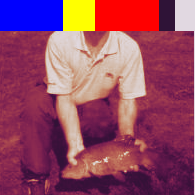

In [ ]:
tcmap = InfCmap(get_cmap("twilight"),
                  below="blue", above="red", nan="yellow")
rgb(tcmap(bad_image[:,:,0])) # Note: Mapped only first channel

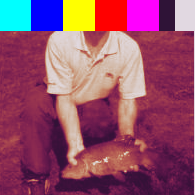

In [ ]:
tcmap = InfCmap(get_cmap("twilight"),
                  below="blue", above="red",
                  nan="yellow", ninf="cyan", pinf="fuchsia")
rgb(tcmap(bad_image)[:,:,0]) # Note: Mapped all channels, show only the mapping for the first.

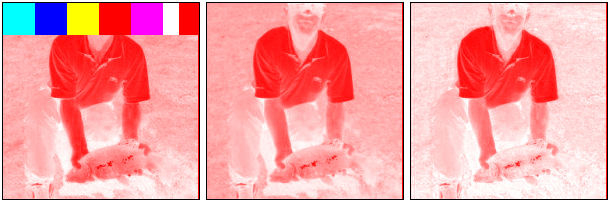

In [ ]:
tcmap = InfCmap(get_cmap("bwr"),
                  below="blue", above="red",
                  nan="yellow", ninf="cyan", pinf="fuchsia")
rgb(tcmap(bad_image.transpose(2,0,1)))

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()